<a href="https://colab.research.google.com/github/DefaultaideN/EncodeBoosting/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install seaborn
#!pip install tensorflow
#!pip install tf_keras_vis

In [ ]:
#Load some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

print("Tensorflow Edition:", tf.__version__)
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)
print("Packages Loaded!")

Tensorflow Edition: 2.4.0
Packages Loaded!


In [ ]:
#inspect GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
n_GPUs = len(physical_devices)
print("Num_GPUs_Available:", n_GPUs)
if n_GPUs>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num_GPUs_Available: 1


In [ ]:
!nvidia-smi

Thu Jan  7 15:18:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#load data from Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
class Toget_transfer_model():
  def __init__(self, model_list, img_process_list, data_path, save_path, name_list):
    self.model_list = model_list
    self.img_process_list = img_process_list
    self.save_path = save_path
    self.data_path = data_path
    self.labels = []
    self.name_list = name_list

  def load_data(self, index, batch_size=16):
    data_path = self.data_path
    single_model = self.model_list[index]
    single_process = self.img_process_list[index]

    input_shape = single_model.layers[0].input_shape[0][1:3]
    image_loader = ImageDataGenerator(preprocessing_function = single_process)
    aug_loader = ImageDataGenerator(
      preprocessing_function = single_process,
      #rescale=1./255,
      rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      vertical_flip=True,
      channel_shift_range=10
      )
    
    print('Train dataset:')
    trainaug_loader = aug_loader.flow_from_directory(directory= data_path+'train', target_size=input_shape, batch_size=batch_size)
    print('Validation dataset:')
    val_loader = image_loader.flow_from_directory(directory= data_path+'val', target_size=input_shape, batch_size=batch_size) 

    return trainaug_loader, val_loader


  def transfer_train_with_model(self, i, train_aug, val_loader, name='model_default', epoch=20):
    name = 'model_'+str(i)
    model = self.model_list[i]
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    if not os.path.exists(self.save_path + name):
      os.mkdir(self.save_path + name)

    checkpoint_filepath = self.save_path + name
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath,
        save_weights_only = False,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True)
    csv_logger = CSVLogger(self.save_path + name + '/train_history.csv', append=False)

    model.fit(x = train_aug,
          steps_per_epoch = len(train_aug),
          epochs = epoch,
          verbose = 2, 
          validation_data = val_loader,
          callbacks = [model_checkpoint_callback, csv_logger]
          ) 

    return model  
  

  def freeze_layers(self, index, layer_to_freeze):
    model = self.model_list[index]
    for layer in model.layers[:layer_to_freeze]:
      layer.trainable = False
    def count_params(model):
      non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
      trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
      return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

    print(count_params(model))#Show number of trainable parameters
    return model
  

  def reshape_model(self, index, encode_shape, layer_to_remove):
    model = self.model_list[index]
    x = model.layers[layer_to_remove-1].output
    flatten = Flatten(name='fla_encode')(x)
    encode = Dense(units=encode_shape, activation='relu', name='encode')(flatten)
    output = Dense(units=4, activation='softmax', name='new_predictions')(encode)
    return keras.Model(inputs=model.input, outputs=output)


  def print_test(self, index):
    single_model = self.model_list[index]
    single_process = self.img_process_list[index]
    input_shape = single_model.layers[0].input_shape[0][1:3]
    image_loader = ImageDataGenerator(preprocessing_function = single_process)

    test_loader = image_loader.flow_from_directory(directory= self.data_path+'test', target_size=input_shape, batch_size=16)
    print('Testing model_{} ...'.format(index))
    results = single_model.evaluate(test_loader)
    print('model_{}: test_loss:{:.3f}, test_auc:{:.3f}\n'.format(index, results[0], results[1]))  


  def plot_decompose(self, encode, index, labels):
    model_name = 'model_'+str(index)+'_'+self.name_list[index]
    from sklearn.manifold import TSNE
    decompiser_tsne = TSNE(n_components=2)
    de_tsne = decompiser_tsne.fit_transform(encode)

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    scatter = ax.scatter(x=de_tsne[:,0], y=de_tsne[:,1], c=labels)
    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
    ax.set_title(model_name+'---tsne')
    ax.add_artist(legend1)

    from sklearn.manifold import Isomap
    decompiser_iso = Isomap(n_components=2, n_neighbors=10)
    de_iso = decompiser_iso.fit_transform(encode)

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    scatter = ax.scatter(x=de_iso[:,0], y=de_iso[:,1], c=labels)
    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
    ax.set_title(model_name+'---Isomap')
    ax.add_artist(legend1)


  def get_decompose(self, index):
    single_model = self.model_list[index]
    single_process = self.img_process_list[index]
    input_shape = single_model.layers[0].input_shape[0][1:3]

    image_loader = ImageDataGenerator(preprocessing_function = single_process)
    test_loader = image_loader.flow_from_directory(directory= self.data_path+'test', shuffle=False,
                            target_size=input_shape, batch_size=16)
    labels = np.array([])
    for step in range(len(test_loader)):
      X, y = test_loader.next()
      labels = np.append(labels, y.argmax(axis=1))
    
    encoder = keras.Model(inputs=[self.model_list[index].input],
              outputs=[self.model_list[index].layers[-2].output])
    single_model = encoder
    single_process = self.img_process_list[index]
    input_shape = single_model.layers[0].input_shape[0][1:3]
    image_loader = ImageDataGenerator(preprocessing_function = single_process)

    model_encode = single_model.predict(test_loader)
    self.plot_decompose(model_encode, index, labels)

    return model_encode


In [ ]:
SAVE_PATH = '/content/drive/My Drive/PAPER/model_trained/'
DATA_PATH = '/content/drive/My Drive/PAPER/data/'

In [ ]:
model_VGG19 = keras.applications.vgg19
model_XCEP = keras.applications.xception
model_EFCb5 = keras.applications.efficientnet
model_RES50 = keras.applications.resnet
NAME_LIST = ['VGG', 'Xcept', 'Efcb5', 'Res50']
model_list = [model_VGG19, model_XCEP, model_EFCb5, model_RES50]

img_process = [model.preprocess_input for model in model_list]
model_list = [model_VGG19.VGG19(), model_XCEP.Xception(), model_EFCb5.EfficientNetB5(), model_RES50.ResNet50()]

train_model = Toget_transfer_model(model_list, img_process, DATA_PATH, SAVE_PATH, NAME_LIST)



In [ ]:
'''
Training with below layers freezed
VGG -3
XCEPT -1
EFCb5 -1
Res50 -1
'''

'''
fix_list = [-3, -1, -1, -1]
model_num = len(train_model.model_list)
for i in [0,1,2,3]:
  train_model.model_list[i] = train_model.reshape_model(i, 500, fix_list[i])
  train_model.model_list[i] = train_model.freeze_layers(i, -2)
  train_loader, val_loader = train_model.load_data(i)
  train_model.model_list[i] = train_model.transfer_train_with_model(i, train_loader, val_loader)
'''

'\nfix_list = [-3, -1, -1, -1]\nmodel_num = len(train_model.model_list)\nfor i in [0,1,2,3]:\n  train_model.model_list[i] = train_model.reshape_model(i, 500, fix_list[i])\n  train_model.model_list[i] = train_model.freeze_layers(i, -2)\n  train_loader, val_loader = train_model.load_data(i)\n  train_model.model_list[i] = train_model.transfer_train_with_model(i, train_loader, val_loader)\n'

In [ ]:
model_loaded = []
for i in range(4):
  model = keras.models.load_model(SAVE_PATH+'model_'+str(i))
  model_loaded.append(model)

Found 1578 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Found 1578 images belonging to 4 classes.
Found 1578 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Found 1578 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


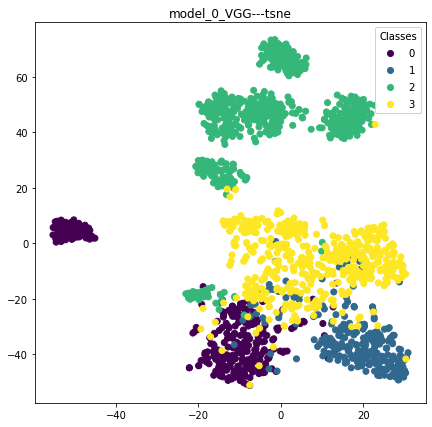

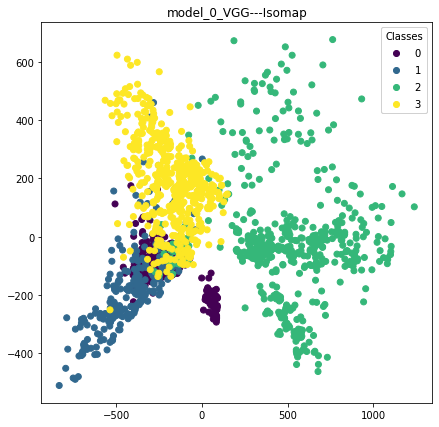

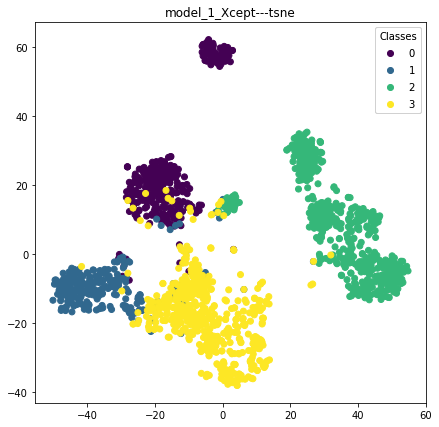

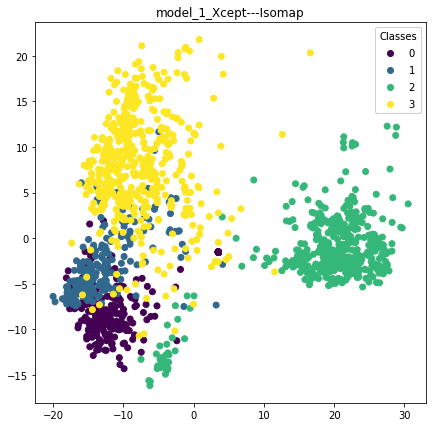

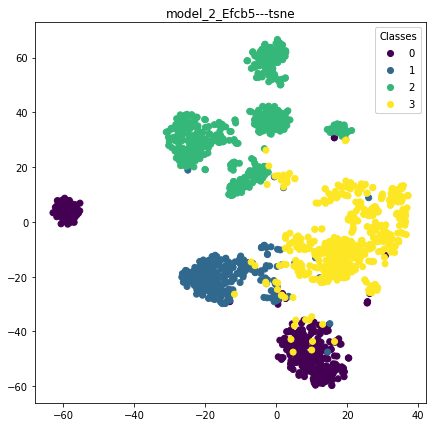

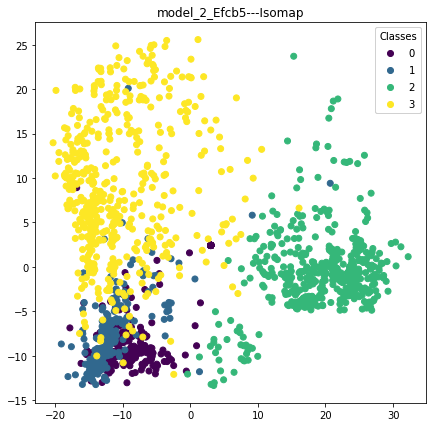

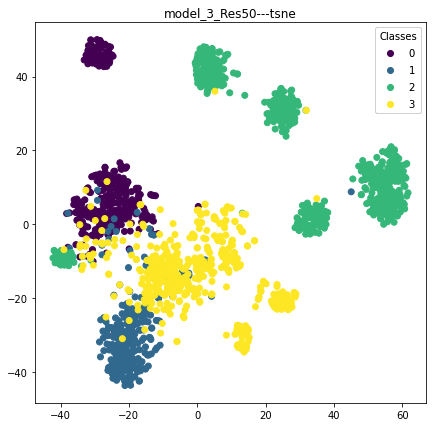

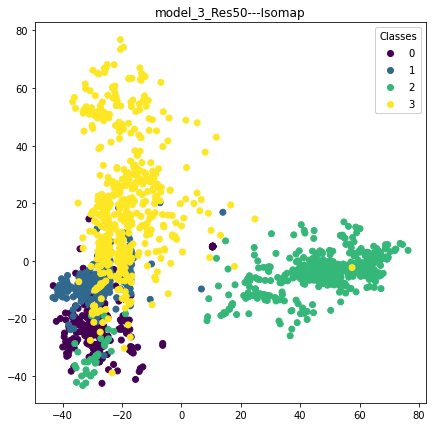

In [ ]:
test_model = Toget_transfer_model(model_loaded, img_process, DATA_PATH, SAVE_PATH, NAME_LIST)
demension = []
for i in range(4):
  decompose = test_model.get_decompose(i)
  demension.append(decompose)


In [ ]:
while True:pass